<a href="https://colab.research.google.com/github/YoheiFukuhara/nlp100-2020/blob/main/09.RNN%2CCNN/81_RNN%E3%81%AB%E3%82%88%E3%82%8B%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ID番号で表現された単語列$\boldsymbol{x} = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列$\boldsymbol{x}$からカテゴリ$y$を予測するモデルとして，次式を実装せよ．
$
\overrightarrow h_0 = 0, \\
\overrightarrow h_t = {\rm \overrightarrow{RNN}}(\mathrm{emb}(x_t), \overrightarrow h_{t-1}), \\
y = {\rm softmax}(W^{(yh)} \overrightarrow h_T + b^{(y)})
$
ただし，$\mathrm{emb}(x) \in \mathbb{R}^{d_w}$は単語埋め込み（単語のone-hot表記から単語ベクトルに変換する関数），$\overrightarrow h_t \in \mathbb{R}^{d_h}$は時刻$t$の隠れ状態ベクトル，${\rm \overrightarrow{RNN}}(x,h)$は入力$x$と前時刻の隠れ状態$h$から次状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である（$d_w, d_h, L$はそれぞれ，単語埋め込みの次元数，隠れ状態ベクトルの次元数，ラベル数である）．RNNユニット${\rm \overrightarrow{RNN}}(x,h)$には様々な構成が考えられるが，典型例として次式が挙げられる．
$
{\rm \overrightarrow{RNN}}(x,h) = g(W^{(hx)} x + W^{(hh)}h + b^{(h)})
$
ただし，$W^{(hx)} \in \mathbb{R}^{d_h \times d_w}，W^{(hh)} \in \mathbb{R}^{d_h \times d_h}, b^{(h)} \in \mathbb{R}^{d_h}$はRNNユニットのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど）である．
なお，この問題ではパラメータの学習を行わず，ランダムに初期化されたパラメータで$y$を計算するだけでよい．次元数などのハイパーパラメータは，$d_w = 300, d_h=50$など，適当な値に設定せよ（以降の問題でも同様である）．

In [ ]:
import nltk
import pandas as pd
import tensorflow as tf
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


!python --version
!pip show google tensorflow nltk pandas

In [ ]:
BASE_PATH = '/content/drive/MyDrive/ColabNotebooks/ML/NLP100_2020/06.MachineLearning/'
max_len = 0

In [ ]:
def get_vocabulary(type_):
    global max_len
    df = pd.read_table(BASE_PATH+type_+'.feature.txt')
    df.info()
    sr_title = df['title'].str.split().explode()
    max_len_ = df['title'].map(lambda x: len(x.split())).max()
    if max_len < max_len_:
        max_len = max_len_
    return [k for k, v in nltk.FreqDist(sr_title).items() if v > 1]

In [ ]:
vocabulary = get_vocabulary('train')
vocabulary.extend(get_vocabulary('valid'))
vocabulary.extend(get_vocabulary('test')) # あまりこだわらずにテストデータセットも追加

# setで重複削除し、タプル形式に設定
tup_voc = tuple(set(vocabulary))

print(f'vocabulary size before removing duplicates: {len(vocabulary)}')
print(f'vocabulary size after removing duplicates: {len(tup_voc)}')
print(f'sample vocabulary: {tup_voc[:10]}')
print(f'max length is {max_len}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10684 entries, 0 to 10683
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     10684 non-null  object
 1   category  10684 non-null  object
dtypes: object(2)
memory usage: 167.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     1336 non-null   object
 1   category  1336 non-null   object
dtypes: object(2)
memory usage: 21.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     1336 non-null   object
 1   category  1336 non-null   object
dtypes: object(2)
memory usage: 21.0+ KB
vocabulary size before removing duplicates: 11089
vocabulary size after removing duplicates: 7802
sa

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(
 output_mode='int',
 vocabulary=tup_voc,
 output_sequence_length=max_len)

vectorize_layer.vocabulary_size()

['', '[UNK]', 'hopeful', 'exchange', 'Slammed', 'ass', 'Dismiss', 'bis', 'Female', 'fate']
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(2, 18), dtype=int64, numpy=
array([[   1, 3758,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [6559,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]])>>


In [ ]:
#https://www.tensorflow.org/text/guide/word_embeddings

# embeddingのデフォルトinitializerであるuniformはrandom_uniform
# https://github.com/keras-team/keras/blob/v2.7.0/keras/initializers/__init__.py#L116

# cuDNN を使うようにGRUは基本はデフォルト値
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU/

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(vectorize_layer.vocabulary_size()+1, 300, mask_zero=True))
model.add(tf.keras.layers.GRU(50))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 18)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 18, 300)           2341500   
                                                                 
 gru (GRU)                   (None, 50)                52800     
                                                                 
 dense (Dense)               (None, 4)                 204       
                                                                 
Total params: 2,394,504
Trainable params: 2,394,504
Non-trainable params: 0
_________________________________________________________________


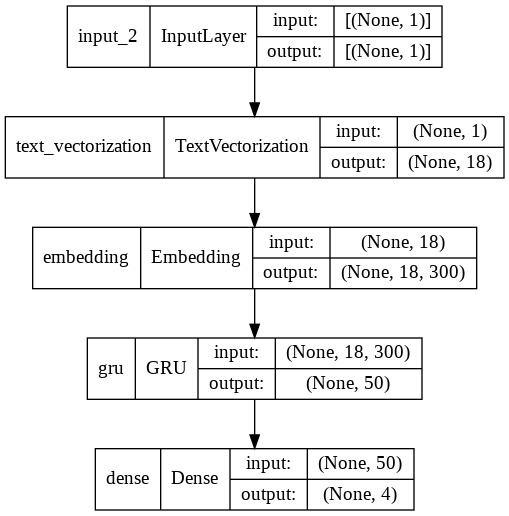

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.predict([['this is a pen']])

array([[0.25213814, 0.24287419, 0.2561083 , 0.24887936]], dtype=float32)